In [24]:
import os

import networkx as nx
import pandas as pd
import seaborn as sns
import numpy as np
import scipy

import matplotlib.pyplot as plt

import json
import powerlaw
import imageio
import warnings
import pickle

from fa2 import ForceAtlas2

# create number for each group to allow use of colormap
from itertools import count

In [25]:
%run Utilyties.ipynb

In [26]:
def percentage(part, whole):
  percentage = 100 * float(part)/float(whole)
  return str(round(percentage, 2)) + "%"

In [27]:
def Average(lst):
    return sum(lst) / len(lst)

# Inizializzazione della rete da file

In [28]:
data = read_data('../data/final/data_complete.json')

G = init_network(data)

In [29]:
G0 = giant_component(G)
nx.write_gexf(G0, "rete_uff.gexf")

In [30]:
network_node_edge(G, 'G')

La rete G ha:

* Numero di nodi =  16675
* Numero di Edge =  52373


# Definizione e analisi delle Echo chambers

In [6]:
forceatlas2 = ForceAtlas2(
                # Behavior alternatives
                outboundAttractionDistribution=False,  # Dissuade hubs
                linLogMode=False,  # NOT IMPLEMENTED
                adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                edgeWeightInfluence=1.0,

                # Performance
                jitterTolerance=1.0,  # Tolerance
                barnesHutOptimize=True,
                barnesHutTheta=1.2,
                multiThreaded=False,  # NOT IMPLEMENTED

                # Tuning
                scalingRatio=2.0,
                strongGravityMode=False,
                gravity=1.0,

                # Log
                verbose=True)

In [8]:
# per generare le posizioni utilizzare il file data.pkl

# positions = forceatlas2.forceatlas2_networkx_layout(G0, pos=None, iterations=1000)

# salvataggio di positions in un file
# a_file = open("data.pkl", "wb") 
# pickle.dump(positions, a_file) 
# a_file.close()

In [31]:
# caricamento di positions dal file 

a_file = open("data.pkl", "rb")
positions = pickle.load(a_file)

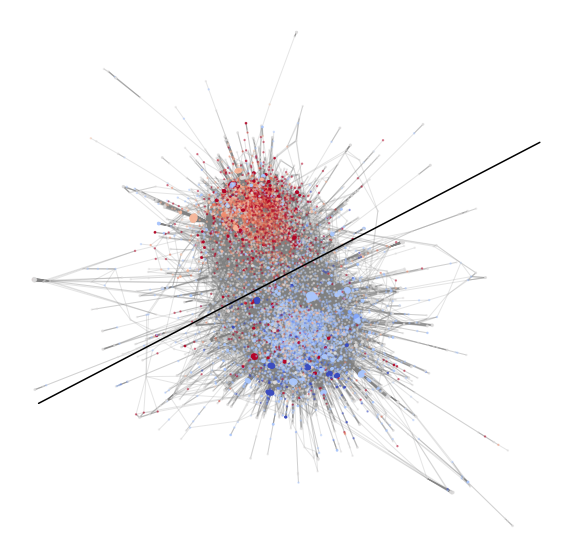

In [10]:
from matplotlib.pyplot import figure
sns.set_style(style='white')
figure(figsize=(10, 10))

nx.draw_networkx_nodes(G0, positions, node_size=2, with_labels=False, 
                       node_color=[G0.nodes[node]['classification'] for node in G0.nodes()], 
                       cmap = 'coolwarm', alpha=0.4)
nx.draw_networkx_edges(G0, positions, edge_color="grey", alpha=0.2)

x = np.linspace(-3000, 3000, 5)
plt.plot(x, 0.6*x+80, linestyle='-', color='black')
plt.axis('off')
plt.show()


In [32]:
# Assegnazione del valore 'red' o 'blue' all'attributo "echo_chaber" ai nodi della rete in base alla posizione rispetto alla retta

for p in positions:
    if (positions[p][1] - 0.6*positions[p][0] - 80 > 0):
        G0.nodes[p]['echo_chamber'] = 'red'
    else:
        G0.nodes[p]['echo_chamber'] = 'blue'

In [33]:
n_red = len([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='red'])
n_blue = len([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='blue'])

print(f"Dimensione delle echo chambers:\n\nRed: {n_red}\nBlue: {n_blue}")

Dimensione delle echo chambers:

Red: 6812
Blue: 9262


In [34]:
H_red = G0.subgraph([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='red'])
H_blue = G0.subgraph([x for x,y in G0.nodes(data=True) if y['echo_chamber']=='blue'])

In [35]:
H0_red = giant_component(H_red) #Sottografo R
H0_blue = giant_component(H_blue) #Sottografo B

## Studio delle partizioni

In [36]:
# calcolo della percentuale di utenti a favore, contrari e neutri 
def partitions_profiling(g):
    # percentuale di pro
    pros = len([x for x,y in g.nodes(data=True) if y['classification']<= -0.5])
    cons = len([x for x,y in g.nodes(data=True) if y['classification']>= 0.5])
    neutrals = (g.number_of_nodes() - pros - cons)
    average = Average([y['classification'] for x,y in g.nodes(data=True)])
    
    print(f"Utenti a favore: {percentage(pros, g.number_of_nodes())}\n"+
          f"Utenti contrari: {percentage(cons, g.number_of_nodes())}%\n"+
          f"Utenti neutri o non classificabili: {percentage(neutrals, g.number_of_nodes())}%\n"+
          f"Opinione media: {round(average,2)}")
    #return pros, cons, neutrals

In [37]:
print(f"Nodi scollegati echo chamber Red: {H_red.number_of_nodes() - H0_red.number_of_nodes()}")
print(f"Nodi scollegati echo chamber Blue: {H_blue.number_of_nodes() - H0_blue.number_of_nodes()}")

Nodi scollegati echo chamber Red: 64
Nodi scollegati echo chamber Blue: 0


In [38]:
network_info(H0_red, 'Echo chamber - red') #Sottografo R

Informazioni sulla rete Echo chamber - red:
 Numero di nodi: 	6748
 Numero di link: 	21163

 Grado medio: 		6.272377000592768
 Transitività: 		0.017872487353660593
 Average clustering: 	0.25087809812159756

 Numero di componenti connesse: 	1
 Diametro: 	11

 Densità: 	0.0009296542167767553

Lunghezza media del cammino più breve 3.7140285141988065


In [15]:
partitions_profiling(H0_red) 

Utenti a favore: 11.41%
Utenti contrari: 65.99%%
Utenti neutri o non classificabili: 22.6%%
Opinione media: 1.23


In [26]:
network_info(H0_blue, 'Echo chamber - blue') #Sottografo B

Informazioni sulla rete Echo chamber - blue:
 Numero di nodi: 	9262
 Numero di link: 	27573

 Grado medio: 		5.954005614338156
 Transitività: 		0.011811854710052598
 Average clustering: 	0.29412270408754554

 Numero di componenti connesse: 	1
 Diametro: 	11

 Densità: 	0.0006429117389415998

Lunghezza media del cammino più breve 3.8561586819864004


In [16]:
partitions_profiling(H0_blue)

Utenti a favore: 69.23%
Utenti contrari: 8.7%%
Utenti neutri o non classificabili: 22.07%%
Opinione media: -0.82


In [17]:
print(f"Numero di edges tra le due echo chambers: {G0.number_of_edges() - (H0_red.number_of_edges()+H0_blue.number_of_edges())} ({round((((G0.number_of_edges() - (H0_red.number_of_edges()+H0_blue.number_of_edges()))/G0.number_of_edges())*100), 2)}%)")

Numero di edges tra le due echo chambers: 3196 (6.15%)


## Studio degli hubs 

In [33]:
# estrae da una lista di utenti quelli autori di almeno un post (esclude utenti solo menzionati)
def extr_real_list(l_hub):
    real_hub = []
    for u in l_hub: 
        for t in data:
            if u==t['user']:
                real_hub.append(u)
    return set(real_hub)

In [34]:
from operator import itemgetter, attrgetter

node_and_degree = G.degree()
hubs = sorted(node_and_degree, key=itemgetter(1), reverse=True)
vip = nx.get_node_attributes(G, 'vip')
C = nx.get_node_attributes(G, 'classification')

In [35]:
n = 2 #percentuale di nodi da considerare hubs
npm = int(round(G.number_of_nodes()*n/1000,0)) #percentuale di nodi sul totale

In [36]:
l_hub_red = []
l_hub_blue = []

print(f"\nLista dei primi {int(npm)} hubs ({n}%° dei nodi dell'intera rete riordinati per grado) \n")
print(f"Rank\tSottografo\tUsername\tClassif.\tGrado\tVip")

i=1
for h in hubs[:npm]: #2%° dei nodi in base al grado
    if H0_red.has_node(h[0]):
        print(f"{i}.\tR\t\t{h[0]} \t{round(C[h[0]],1)} \t\t{h[1]} \t{vip[h[0]]}")
        l_hub_red.append(h[0])
    else:    
    #elif H0_blue.has_node(h[0]):
        print(f"{i}.\tB\t\t{h[0]} \t{round(C[h[0]],1)} \t\t{h[1]} \t{vip[h[0]]}")
        l_hub_blue.append(h[0])
    i+=1   


Lista dei primi 33 hubs (2%° dei nodi dell'intera rete riordinati per grado) 

Rank	Sottografo	Username	Classif.	Grado	Vip
1.	B		repubblica 	0 		1609 	2
2.	B		PBerizzi 	-1.0 		1252 	1
3.	B		feltrinellied 	0 		1192 	1
4.	R		Giorgiolaporta 	1.7 		1100 	1
5.	R		fratotolo2 	2.2 		892 	0
6.	R		IlPrimatoN 	3.0 		891 	1
7.	R		lefrasidiosho 	1.0 		860 	2
8.	R		FedericoRampini 	0 		788 	1
9.	R		Gianmar26145917 	2.5 		773 	0
10.	B		MarcoNoel19 	-1.0 		740 	0
11.	R		Vivo_Azzurro 	0 		698 	2
12.	B		robertosaviano 	-3.0 		651 	2
13.	R		Azzurri 	0 		634 	2
14.	R		Azzurri_Ar 	0 		629 	1
15.	B		ProfCampagna 	-3.0 		577 	1
16.	B		manginobrioches 	-3.0 		555 	1
17.	R		LeonardoPanetta 	1.0 		548 	0
18.	B		TendenzaPerche 	0.8 		547 	0
19.	B		FIGC 	0 		461 	1
20.	B		JFSebastian146 	-0.9 		445 	0
21.	B		ValeriaParrell2 	-1.0 		440 	0
22.	B		maurobiani 	-1.0 		430 	1
23.	B		kiapasqualini 	0 		399 	0
24.	B		espressonline 	0 		387 	2
25.	B		HuffPostItalia 	0 		375 	2
26.	R		strange_days_82 	0.8 		370 	0
27.	B

In [37]:
real_hub_blue = extr_real_list(l_hub_blue)
real_hub_red = extr_real_list(l_hub_red)

In [61]:
real_hubs = set.union(real_hub_blue, real_hub_red)
print(f"Numero di hubs ATTIVI: {len(real_hubs)}")

Numero di hubs ATTIVI: 20


In [38]:
print(f"Hubs ATTIVI del sottografo R:\n")
for x in real_hub_red:
    print(f"{x} \tC: {round(C[x],1)} \tvip: {vip[x]} ")
    
#RED LeonardoPanetta 	c: 1.0 		vip: 0 numero di followers: 2251
#RED Gianmar26145917 	c: 2.54 	vip: 0 numero di followers: 11328
#RED strange_days_82 	c: 0.83 	vip: 0 numero di followers: 4241
#RED fratotolo2 		c: 2.2 		vip: 0 numero di followers: 6222

Hubs ATTIVI del sottografo R:

GiuseppePalma78 	C: 1.5 	vip: 1 
strange_days_82 	C: 0.8 	vip: 0 
LeonardoPanetta 	C: 1.0 	vip: 0 
Gianmar26145917 	C: 2.5 	vip: 0 
IlPrimatoN 	C: 3.0 	vip: 1 
Giorgiolaporta 	C: 1.7 	vip: 1 
fratotolo2 	C: 2.2 	vip: 0 
lefrasidiosho 	C: 1.0 	vip: 2 


In [39]:
print(f"Hubs ATTIVI del sottografo B:\n")
for x in real_hub_blue:
    print(f"{x} \tC: {round(C[x],1)} \tvip: {vip[x]} ")
    
#BLUE JFSebastian146 	c: -0.93 	vip: 0 numero di followers: 8294
#BLUE TendenzaPerche 	c: 0.83 	vip: 0 # utente non rilevante
#BLUE ValeriaParrell2 	c: -1.0 	vip: 0 numero di followers: 17354
#BLUE AlbertoLetizia2 	c: -1.0 	vip: 0 numero di followers: 15170
#BLUE MarcoNoel19 		c: -1.0 	vip: 0 numero di followers: 10573

Hubs ATTIVI del sottografo B:

AlbertoLetizia2 	C: -1.0 	vip: 0 
PBerizzi 	C: -1.0 	vip: 1 
TendenzaPerche 	C: 0.8 	vip: 0 
perchetendenza 	C: -1.0 	vip: 1 
ProfCampagna 	C: -3.0 	vip: 1 
ValeriaParrell2 	C: -1.0 	vip: 0 
JFSebastian146 	C: -0.9 	vip: 0 
robertosaviano 	C: -3.0 	vip: 2 
MarcoNoel19 	C: -1.0 	vip: 0 
pietroraffa 	C: -3.0 	vip: 1 
maurobiani 	C: -1.0 	vip: 1 
manginobrioches 	C: -3.0 	vip: 1 


### Hubs vip 

In [40]:
vips1_2 = [x for x,y in G.nodes(data=True) if (y['vip']==2 or y['vip']==1)]
vips_2 = [x for x,y in G.nodes(data=True) if (y['vip']==2)]

print(f"Numero di utenti con più di 20'000 followers:\t\t {len(vips1_2)}")
print(f"Numero di utenti attivi con più di 20'000 followers:\t {len(extr_real_list(vips1_2))}")

print(f"\nNumero di utenti con più di 200'000 followers:\t\t {len(vips_2)}")
print(f"Numero di utenti attivi con più di 200'000 followers:\t {len(extr_real_list(vips_2))}")

Numero di utenti con più di 20'000 followers:		 895
Numero di utenti attivi con più di 20'000 followers:	 159

Numero di utenti con più di 200'000 followers:		 378
Numero di utenti attivi con più di 200'000 followers:	 13


In [41]:
l_vip_red = []
l_vip_blue = []

print(f"\nLista degli utenti VIP nei primi {int(npm)} hubs ({n}%° dei nodi dell'intera rete riordinati per grado) \n")
print(f"Rank\tSottografo\tUsername\tClassif.\tGrado\tVip")

i=1
for h in hubs[:npm]:
    if vip[h[0]]>0:
        if H0_red.has_node(h[0]):
            l_vip_red.append(h[0])
            print(f"{i}.\tR\t\t{h[0]} \t{round(C[h[0]],2)} \t\t{h[1]} \t{vip[h[0]]} ")
        else:
            l_vip_blue.append(h[0])
            print(f"{i}.\tB\t\t{h[0]} \t{round(C[h[0]],2)} \t\t{h[1]} \t{vip[h[0]]} ")
    i+=1


Lista degli utenti VIP nei primi 33 hubs (2%° dei nodi dell'intera rete riordinati per grado) 

Rank	Sottografo	Username	Classif.	Grado	Vip
1.	B		repubblica 	0 		1609 	2 
2.	B		PBerizzi 	-1.0 		1252 	1 
3.	B		feltrinellied 	0 		1192 	1 
4.	R		Giorgiolaporta 	1.67 		1100 	1 
6.	R		IlPrimatoN 	3.0 		891 	1 
7.	R		lefrasidiosho 	1.0 		860 	2 
8.	R		FedericoRampini 	0 		788 	1 
11.	R		Vivo_Azzurro 	0 		698 	2 
12.	B		robertosaviano 	-3.0 		651 	2 
13.	R		Azzurri 	0 		634 	2 
14.	R		Azzurri_Ar 	0 		629 	1 
15.	B		ProfCampagna 	-3.0 		577 	1 
16.	B		manginobrioches 	-3.0 		555 	1 
19.	B		FIGC 	0 		461 	1 
22.	B		maurobiani 	-1.0 		430 	1 
24.	B		espressonline 	0 		387 	2 
25.	B		HuffPostItalia 	0 		375 	2 
27.	B		pietroraffa 	-3.0 		365 	1 
29.	B		La7tv 	0 		356 	2 
30.	B		perchetendenza 	-1.0 		350 	1 
31.	B		chiellini 	0 		345 	2 
32.	B		ilmanifesto 	0 		342 	1 
33.	R		GiuseppePalma78 	1.5 		337 	1 


In [26]:
print(f"Numero di hubs vip:\t{len(l_vip_red)+len(l_vip_blue)}")

Numero di hubs vip:	23


In [42]:
real_hubs_vip = set.union(extr_real_list(l_vip_red), extr_real_list(l_vip_blue))
print(f"Numero di hubs VIP ATTIVI: {len(real_hubs_vip)}")

Numero di hubs VIP ATTIVI: 11


In [43]:
print(f"Hubs VIP ATTIVI del sottografo R:\n") # esclusi i nodi solo menzionati
for x in extr_real_list(l_vip_red):
    print(f"{x} \tC: {round(C[x],1)} \tvip: {vip[x]} ")

Hubs VIP ATTIVI del sottografo R:

IlPrimatoN 	C: 3.0 	vip: 1 
Giorgiolaporta 	C: 1.7 	vip: 1 
lefrasidiosho 	C: 1.0 	vip: 2 
GiuseppePalma78 	C: 1.5 	vip: 1 


In [44]:
print(f"Hubs VIP ATTIVI del sottografo B:\n")  # esclusi i nodi solo menzionati
for x in extr_real_list(l_vip_blue):
    print(f"{x} \tC: {round(C[x],1)} \tvip: {vip[x]} ")

Hubs VIP ATTIVI del sottografo B:

PBerizzi 	C: -1.0 	vip: 1 
perchetendenza 	C: -1.0 	vip: 1 
ProfCampagna 	C: -3.0 	vip: 1 
robertosaviano 	C: -3.0 	vip: 2 
pietroraffa 	C: -3.0 	vip: 1 
maurobiani 	C: -1.0 	vip: 1 
manginobrioches 	C: -3.0 	vip: 1 


## Domanda: come l'intervento degli hub influenza la conversazione

Al fine di rendere più consistente la nostra ricerca, scegliamo di svolgere questa analisi sugli utenti autori di almeno due tweet. 

In [18]:
ranges = [
    ['2021-06-10', '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14'], # Italia - Turchia -> Italia - Svizzera
    ['2021-06-15', '2021-06-16', '2021-06-17', '2021-06-18', '2021-06-19'], # Italia - Svizzera -> Italia - Galles
    ['2021-06-20', '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24'], # Italia - Galles -> Italia - Austria
    ['2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28', '2021-06-29'], # Italia - Austria -> Italia - Belgio
    ['2021-06-30', '2021-07-01', '2021-07-02', '2021-07-03', '2021-07-04'], # Italia - Belgio -> Italia - Spagna
    ['2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08', '2021-07-09'], # Italia - Spagna -> Italia - Inghilterra
    ['2021-07-10', '2021-07-11', '2021-07-12'],                             # Italia - Inghilterra 
]
snapshots = get_snapshot("../data/final/data_complete.json", ranges)

In [19]:
tweet_list = []
for tweet in data:
    tweet_list.append(tweet)
tweet_list = pd.DataFrame(tweet_list)

v = tweet_list.user.value_counts()
user_list_occ = tweet_list[tweet_list.user.isin(v.index[v.gt(1)])].groupby('user').mean() # lista di utenti autori di almeno 2 tweet

In [20]:
def discretize_opinion(G):
    for node in G.nodes():
        if G.nodes[node]['classification'] < 0.5 and G.nodes[node]['classification'] > -0.5:
            G.nodes[node]['classification'] = 0
        elif G.nodes[node]['classification'] >= 0.5:
            G.nodes[node]['classification'] = 1
        else:
            G.nodes[node]['classification'] = -1

In [21]:
def get_ass_mix(G):
    discretize_opinion(G) # discretizza l'opinione in -1 (a favore), 1 (contrari), 0 (neutri/non classificabili)
    return nx.attribute_assortativity_coefficient(G, "classification") 

In [22]:
# studio sulla  opinione media dei vicini CN(u) rispetto all’opinione media di un utente Cu
def neighbors_av_opinion(G, T, lista_ass_mix): 
    nx.set_node_attributes(G, 0, "neighbours_opinion") # inizializzazione dell'attributo
    
    # calcolo e assegnazione del valore dell'attributo neighbours_opinion ad ogni nodo
    for node in G.nodes():
        if node in user_list_occ.index: 
            for n in(G.neighbors(node)):
                G.nodes[node]['neighbours_opinion'] += G.nodes[n]["classification"]
            if (G.degree[node] != 0): 
                G.nodes[node]['neighbours_opinion'] = G.nodes[node]['neighbours_opinion']/G.degree[node]
            else:
                G.nodes[node]['neighbours_opinion'] = G.nodes[node]['classification']
    
    # creazione del dizionario
    n_class = {}
    for node in G.nodes():
        if node in user_list_occ.index:
            n_class[node] = [G.nodes[node]['classification']]
            n_class[node].append(G.nodes[node]['neighbours_opinion'])
    
    # creazione del dataframe
    df_class = pd.DataFrame.from_dict(n_class, orient='index',
                           columns=['opinion','neighbours_opinion'])
    
    # discretizzazione dell'opinione 
    df_class["class"] = np.where(
        df_class["opinion"] >= 0.5, 'contro', 
        np.where(df_class["opinion"] <= -0.5, 'pro', 'neutro')
    )
    
    ### PLOT ###
    #sns.jointplot(data = df_class, x = "opinion", y = "neighbours_opinion", kind = "kde")
    plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_facecolor("black")
    
    ax = sns.kdeplot(data = df_class,  x = "opinion", y = "neighbours_opinion", 
                fill=True, thresh=0, levels=100, cmap="CMRmap") #ax=axes[T]) #o mako
    ax.set(xlim=(-3, 3), ylim=(-3, 3))
    
    # calcolo del p-value e del coefficiente di pearson 
    r, p = scipy.stats.pearsonr(df_class['opinion'], df_class['neighbours_opinion'])
    print(f"Coefficiente di Pearson: {round(r,2)}\tp-value: {round(p,4)} \n")
    
    # calcolo dell'assortative mixing 
    G_tmp = G.copy()
    lista_ass_mix.append(get_ass_mix(G_tmp))
    
    tempo = T+1
    ax.text(x=0.02, y=0.98, transform = ax.transAxes, s="Pearson: %.2f" % r,\
        fontsize=14, verticalalignment='top', horizontalalignment='left', color='white')
    ax.text(x=0.02, y=0.92, transform = ax.transAxes, s="Assortative Mixing: %.2f" % lista_ass_mix[T],\
        fontsize=14, verticalalignment='top', horizontalalignment='left', color='white')
    ax.text(x=0.88, y=0.06, transform = ax.transAxes, s=r"t = %.0f" % tempo,\
        fontsize=14, verticalalignment='top', horizontalalignment='left', color='white')
    
    # create file name and append it to a list
    #filename = f'Density_2tweets_{T}.png'
    #filenames.append(filename)
    
    # save frame
    #plt.savefig(filename, transparent=True)
    #plt.close()
    
    plt.show()    

Coefficiente di Pearson: 0.46	p-value: 0.0004 



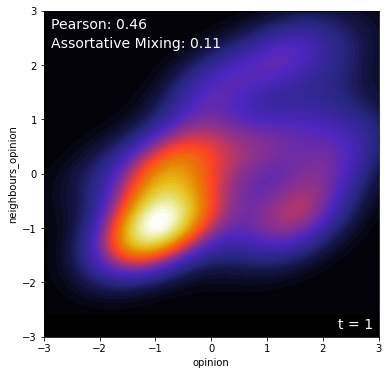

Coefficiente di Pearson: 0.49	p-value: 0.0 



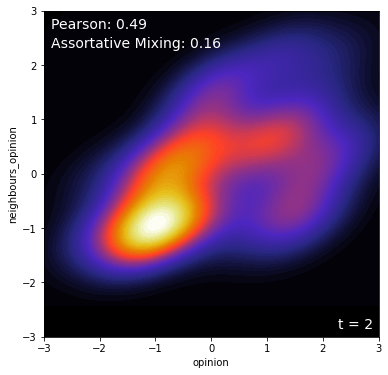

Coefficiente di Pearson: 0.7	p-value: 0.0 



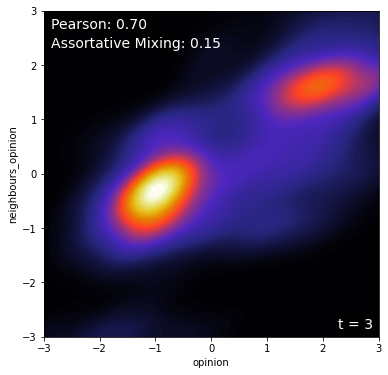

Coefficiente di Pearson: 0.82	p-value: 0.0 



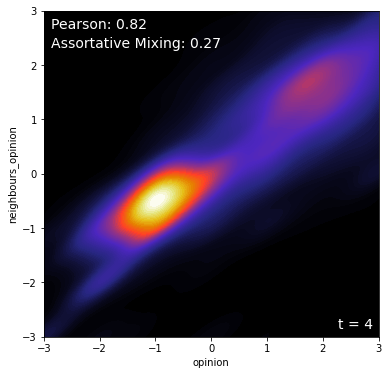

Coefficiente di Pearson: 0.83	p-value: 0.0 



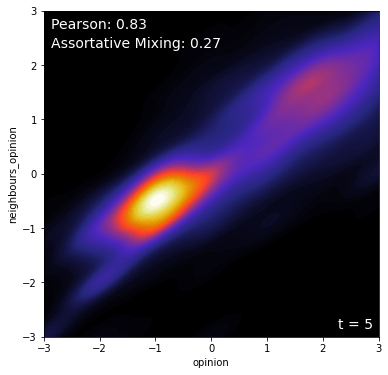

Coefficiente di Pearson: 0.83	p-value: 0.0 



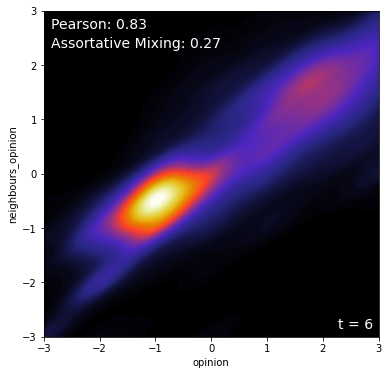

Coefficiente di Pearson: 0.84	p-value: 0.0 



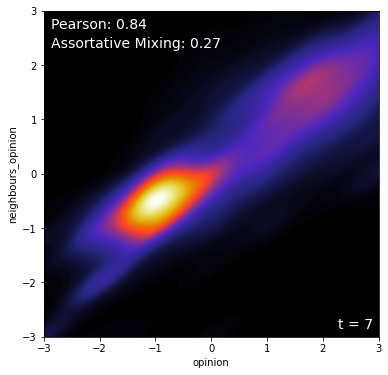

In [23]:
G=nx.Graph()
T = 0
lista_ass_mix = []
filenames = []   

for snap in snapshots:
    build_network(snap, G)
    neighbors_av_opinion(G, T, lista_ass_mix)
    T += 1  

In [62]:
G = nx.Graph()
c = nx.Graph()

c_red = nx.Graph()
c_blue = nx.Graph()

n_nodes = []
n_nodes_favore = []
n_nodes_contro = []
n_nodes_neutri = []

r_hubs = 0
b_hubs = 0
n_hubs = 0

l_r_hubs = []
l_b_hubs = []
l_n_hubs = []

r_mean_size = []
b_mean_size = []
mean_size = []

perc_net = []
r_perc_ego = []
b_perc_ego = []

time = 1

for snap, dates in zip(snapshots, ranges):
    
    print(f"--- Network dal: {dates[0]} al {dates[-1]} (Tempo {time})--- \n")
    build_network(snap, G)
    
    n_nodes.append(G.number_of_nodes())
    n_nodes_contro.append(G.subgraph([x for x,y in G0.nodes(data=True) if y['classification']>=0.5]).number_of_nodes())
    n_nodes_favore.append(G.subgraph([x for x,y in G0.nodes(data=True) if y['classification']<=-0.5]).number_of_nodes())
    n_nodes_neutri.append(G.subgraph([x for x,y in G0.nodes(data=True) if (y['classification']>-0.5) & (y['classification']<0.5)]).number_of_nodes())
    
    for node in real_hubs:
        if G.has_node(node):
            n_hubs += 1
            node_ego = nx.ego_graph(G, node)
            c = nx.compose(c, node_ego)
            if node in real_hub_red:
                c_red = nx.compose(c_red, node_ego)
                r_hubs += 1
            elif node in real_hub_blue:
                c_blue = nx.compose(c_blue, node_ego)
                b_hubs += 1
                
    l_r_hubs.append(r_hubs)
    l_b_hubs.append(b_hubs)
    l_n_hubs.append(n_hubs)
    
    r_mean_size.append(c_red.number_of_nodes()/r_hubs)
    b_mean_size.append(c_blue.number_of_nodes()/b_hubs)
    mean_size.append(c.number_of_nodes()/n_hubs)
    
    perc_net.append(round(c.number_of_nodes()/G.number_of_nodes()*100, 2))
    r_perc_ego.append(round(c_red.number_of_nodes()/c.number_of_nodes()*100, 2))
    b_perc_ego.append(round(c_blue.number_of_nodes()/c.number_of_nodes()*100, 2))
    
    print(f"Hubs: {n_hubs}" + 
          f"\nNodi collegati agli hubs: {c.number_of_nodes()} ({perc_net[-1]}% della rete)" + #Numero totale di nodi dell'unione delle ego-networks degli hubs
          f"\nHubs R: {r_hubs}" +
          f"\n\tNodi collegati agli hubs R: {c_red.number_of_nodes()} ({round(c_red.number_of_nodes()/G.number_of_nodes()*100, 2)}% della rete, {r_perc_ego[-1]}% dell'unione delle ego-networks di tutti gli hubs)" +
          f"\n\tDimensione media degli hubs R: {round(r_mean_size[-1],1)}" +
          f"\nHubs B: {b_hubs}" +
          f"\n\tNodi collegati agli hubs B: {c_blue.number_of_nodes()} ({round(c_blue.number_of_nodes()/G.number_of_nodes()*100, 2)}% della rete, {b_perc_ego[-1]}% dell'unione delle ego-networks di tutti gli hubs)" + 
          f"\n\tDimensione media degli hubs B: {round(b_mean_size[-1],1)}" +
          f"\nNodi collegati sia ad hubs R che ad hubs B: {-c.number_of_nodes()+c_red.number_of_nodes()+c_blue.number_of_nodes()} ({round((-c.number_of_nodes()+c_red.number_of_nodes()+c_blue.number_of_nodes())/G.number_of_nodes()*100, 2)}% della rete)\n\n")
    
    r_hubs = 0
    b_hubs = 0
    n_hubs = 0
    time += 1

--- Network dal: 2021-06-10 al 2021-06-14 (Tempo 1)--- 

Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  53
* TOT Quote =  4
* TOT Mentions =  113
* TOT Reply =  5


Hubs: 4
Nodi collegati agli hubs: 14 (15.56% della rete)
Hubs R: 3
	Nodi collegati agli hubs R: 10 (11.11% della rete, 71.43% dell'unione delle ego-networks di tutti gli hubs)
	Dimensione media degli hubs R: 3.3
Hubs B: 1
	Nodi collegati agli hubs B: 4 (4.44% della rete, 28.57% dell'unione delle ego-networks di tutti gli hubs)
	Dimensione media degli hubs B: 4.0
Nodi collegati sia ad hubs R che ad hubs B: 0 (0.0% della rete)


--- Network dal: 2021-06-15 al 2021-06-19 (Tempo 2)--- 

Alcune informazioni iniziali sui dati sono:
* TOT Retweet =  19
* TOT Quote =  6
* TOT Mentions =  24
* TOT Reply =  0


Hubs: 5
Nodi collegati agli hubs: 19 (15.97% della rete)
Hubs R: 3
	Nodi collegati agli hubs R: 10 (8.4% della rete, 52.63% dell'unione delle ego-networks di tutti gli hubs)
	Dimensione media degli hubs R: 3.3
Hu

In [66]:
columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
df_crescita_rete = pd.DataFrame([n_nodes_favore, n_nodes_contro, n_nodes], 
                                columns = columns, 
                                index = ['nodi a favore', 'nodi contrari', 'nodi totali'])
df_crescita_rete

,T1,T2,T3,T4,T5,T6,T7
nodi a favore,44,58,1618,6848,7089,7118,7207
nodi contrari,27,34,1357,4981,5219,5225,5264
nodi totali,90,119,3677,15539,16374,16445,16675


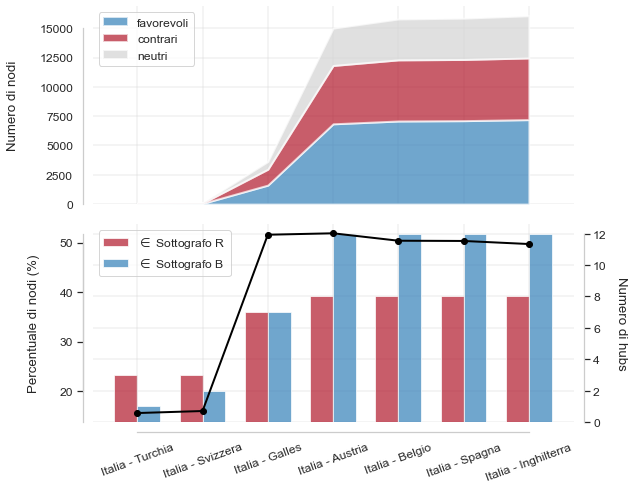

In [68]:
labels = ["Italia - Turchia", 
          "Italia - Svizzera", 
          "Italia - Galles", 
          "Italia - Austria", 
          "Italia - Belgio", 
          "Italia - Spagna", 
          "Italia - Inghilterra"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

sns.set(rc={'figure.figsize':(9,7), "lines.linewidth": 0.9, "grid.linewidth": 0.4}, font_scale=1.1)
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 1, sharex=True)

y=[n_nodes_favore, n_nodes_contro, n_nodes_neutri]
ax[0].stackplot(x,y, 
                colors = ['#3480b9', '#b1182b', '#d4d4d452'],  alpha=.7,  
                labels=['favorevoli','contrari', 'neutri'], 
                linewidth=2)
ax[0].set_ylabel('Numero di nodi', rotation=90, labelpad=20)
ax[0].set_xticks(x)
ax[0].legend(loc='upper left')

ax[1].plot(perc_net,
         linestyle='-',
         marker='o', color='black', linewidth=2.0)


ax2 = ax[1].twinx()
ax2.bar(x - width/2, l_r_hubs, width, color = '#b1182b', alpha=.7, label=r'$\in$ Sottografo R')
ax2.bar(x + width/2, l_b_hubs, width, color = '#3480b9', alpha=.7, label=r'$\in$ Sottografo B')

ax2.set_ylabel('Numero di hubs', rotation=-90, labelpad=20)
ax2.legend(loc='upper left')

# move ax in front
ax[1].set_zorder(1)
ax[1].patch.set_visible(False)

ax[1].set_ylabel('Percentuale di nodi (%)', labelpad=20)
ax[1].set_xticks(x)
ax[1].yaxis.grid(False)

sns.despine(top=True, right=True, left=False, bottom=True, offset=10, trim=True, ax = ax[0])
sns.despine(top=True, right=False, left=False, bottom=True, offset=10, trim=True, ax = ax2)
sns.despine(top=True, right=False, left=False, bottom=True, offset=10, trim=True, ax = ax[1])
sns.despine(offset=10, trim=True, ax = ax[1])

ax[1].set_xticklabels(labels, rotation=20)

fig.tight_layout()
plt.show()

# Centrality & Assortative Mixing

In [42]:
import matplotlib.colors as mcolors

# Support function to plot networks (only small graphs)
def draw_net(G, pos, measures, measure_name):
    
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=1, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    #labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

## Degree Centrality

In [43]:
degrees_red = dict(H0_red.degree()) # degree centraliry dei nodi del Sottografo R

In [44]:
top_score_print(15, degrees_red, order=True)

Giorgiolaporta 	 1082
IlPrimatoN 	 885
fratotolo2 	 879
lefrasidiosho 	 820
FedericoRampini 	 781
Gianmar26145917 	 765
LeonardoPanetta 	 545
Vivo_Azzurro 	 545
Azzurri 	 506
Azzurri_Ar 	 501
strange_days_82 	 367
GiuseppePalma78 	 336
EsercitoCrucian 	 316
ItalicaTestudo 	 220
pdnetwork 	 206


In [45]:
degrees_blue = dict(H0_blue.degree()) # degree centraliry dei nodi del Sottografo B

In [46]:
top_score_print(15, degrees_blue, order=True)

repubblica 	 1413
PBerizzi 	 1079
feltrinellied 	 1047
MarcoNoel19 	 740
ProfCampagna 	 566
robertosaviano 	 541
manginobrioches 	 533
TendenzaPerche 	 529
ValeriaParrell2 	 436
maurobiani 	 424
kiapasqualini 	 395
FIGC 	 383
espressonline 	 381
pietroraffa 	 361
AlbertoLetizia2 	 361


## Closeness centrality

Measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph. Thus, <b>the more central a node is, the closer it is to all other nodes</b>.

In [47]:
closeness_red = nx.closeness_centrality(H0_red) # closeness centraliry dei nodi del Sottografo R

In [48]:
top_score_print(15, closeness_red, order=True)

fratotolo2 	 0.4183148366296733
LPincia 	 0.41405339061061674
IlPrimatoN 	 0.4121060346933789
adrianobusolin 	 0.4095793116008013
Patriota_ITA_ 	 0.40469049904030713
jobwithinternet 	 0.4017267043763025
Giorgiolaporta 	 0.4016310494672302
Gianmar26145917 	 0.4013443578609244
aspettaaspetta 	 0.40089126559714794
2014Monaco 	 0.3997985304574544
elena_elnmrl15 	 0.3972562411681583
attilascuola 	 0.3969991173874669
Vivo_Azzurro 	 0.3950002927229085
FedericoRampini 	 0.39391639420831387
LuceChiara1211 	 0.3930214947282577


In [49]:
closeness_blue = nx.closeness_centrality(H0_blue) # closeness centraliry dei nodi del Sottografo B

In [50]:
top_score_print(15, closeness_blue, order=True)

JFSebastian146 	 0.43124563445867287
repubblica 	 0.39425287356321836
PBerizzi 	 0.3812366211098304
Nena_Nina_Schi 	 0.38017241379310346
pirex70 	 0.3777378961536893
LilianaArmato 	 0.3774146222185997
anubi_matt 	 0.37666246390368896
feltrinellied 	 0.3760201388606927
v_m_a_x_i_m_o 	 0.3754865390853065
mgabrielladavid 	 0.3730363328768227
1969Tonger 	 0.37294619845360827
FIGC 	 0.37276606021574626
XYZxyzY6 	 0.3712418824661268
Lucia05149332 	 0.37030668959174695
blusewillis1 	 0.37024747131491625


## Eigenvector centrality

Measure of the <b>influence</b> of a node in a network.

In [69]:
eigenvector_red = nx.eigenvector_centrality(H0_red)

In [70]:
top_score_print(15, eigenvector_red, order=True)

fratotolo2 	 0.29539076709297174
IlPrimatoN 	 0.2864610053788299
FedericoRampini 	 0.23278904295223363
Gianmar26145917 	 0.2111033596329335
Giorgiolaporta 	 0.20304722435425626
Vivo_Azzurro 	 0.18412659500076112
Azzurri 	 0.1754915592460786
Azzurri_Ar 	 0.17498360795750748
ItalicaTestudo 	 0.09912780121391195
strange_days_82 	 0.09799964956309641
EnricoLetta 	 0.08829037453464286
LeonardoPanetta 	 0.07871728286939363
jobwithinternet 	 0.07459679579701271
pdnetwork 	 0.07458240065831558
2014Monaco 	 0.07305347951672098


In [71]:
eigenvector_blue = nx.eigenvector_centrality(H0_blue)

In [72]:
top_score_print(15, eigenvector_blue, order=True)

repubblica 	 0.386428135117358
PBerizzi 	 0.30404326120991265
feltrinellied 	 0.29359565806258964
maurobiani 	 0.14986153408436367
espressonline 	 0.12812176088786523
La7tv 	 0.12440371893119531
ilmanifesto 	 0.12317687478578933
isiciliani 	 0.12247813178462785
aznonviolenta 	 0.12247813178462785
nonsonpago1 	 0.08397983284616192
anubi_matt 	 0.0788752954168786
_Nico_Piro_ 	 0.07469530948183692
mgabrielladavid 	 0.0715390639634076
JFSebastian146 	 0.07075319202454675
MarcoNoel19 	 0.06569360763331408
